## Professional XGBoost Workflow For Beginners with GPU-acceleration

 👋 ## Introduction

In this notebook, we’ll build a real-world machine learning workflow using the full 2023 Yellow Taxi Trip Data from the City of New York, or a smaller version of it located in the current directory: Distilled_2023_Yellow_Taxi_Trip_Data.csv.

Instead of "hello world" examples, we’ll use millions of real taxi rides to explore what actually makes people tip more in taxis — distance, time of day, passengers, or something else? Step by step, we’ll clean and prepare the data, handle missing values and anomalies, and train an XGBoost model on GPU using cuDF Pandas and RAPIDS RMM for memory management.

I hope this notebook brings you clarity, confidence, and inspiration on your data-science journey - keep learning and exploring! 🚀

⚙️ # Manage GPU Memory

When working with large datasets, we need to manage how memory is distributed between different parts of the workflow. Since we’re running everything on the GPU, we can use RAPIDS Memory Manager (RMM) to control how VRAM is allocated — deciding which module gets what, and keeping our workflow stable and efficient.

Below, we set the initial_pool_size to about half of your GPU’s total VRAM. For example: if you have RTX 4080 with 16GB of VRAM - then set initial_pool_size="8GB".

When we do so, we allocate half of our memory to cuDF Pandas, and leave the rest of it available. cuDF pandas is using RMM by default, so if we restrict the RMM memory pool, it also restricts cuDF Pandas. XGBoost is not using RMM by default, but we can set it up to.

## 📥 Load Dataset

When we work with giant datasets, traditional pandas often runs out of memory or slows down dramatically. To solve this, we’ll load our data with cuDF Pandas, which runs the good old Pandas commands — just on the GPU! 🐼

It’s a simple one-line switch that gives us full GPU acceleration with no code changes. So instead of chunking or splitting our files to run on CPU, we can just load millions of rows smoothly, keeping the workflow clean and professional.

In [6]:
%cd /content/drive/MyDrive/nyc_taxi_project/nyc_taxi_xgboost_lab/



/content/drive/MyDrive/nyc_taxi_project/nyc_taxi_xgboost_lab


In [7]:
!ls /content/drive/MyDrive/nyc_taxi_project/nyc_taxi_xgboost_lab/

AdvancedWorkflow.ipynb			  NYC_Taxi_XGBoost_Abukar.ipynb
Distilled_2023_Yellow_Taxi_Trip_Data.csv  README.md
LICENSE					  TutorialWorkflow.ipynb
nyc_taxi_5M.parquet


In [45]:
import pandas as pd
import os

# define dataset path
dataset_path = "/content/drive/MyDrive/nyc_taxi_project/nyc_taxi_xgboost_lab/Distilled_2023_Yellow_Taxi_Trip_Data.csv"

# load dataset from Drive
if os.path.exists(dataset_path):
    print("✅ Loading dataset from Google Drive...")
    df = pd.read_csv(dataset_path)
    print(f"✅ Dataset loaded successfully! Shape: {df.shape}")
else:
    print("❌ Dataset file not found at:", dataset_path)


✅ Loading dataset from Google Drive...
✅ Dataset loaded successfully! Shape: (5000000, 19)


https://data.cityofnewyork.us/Transportation/2023-Yellow-Taxi-Trip-Data/4b4i-vvec/about_data

#metadata
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

- look at the Yellow Trips Data Dictionary to understand the relevant of the  features and the lower and upper boundary of the data.  for examble you will see that the RatecodeID will show missing values and has NaN on all records. so we will need to replace this with a code of 99.

- the trip distance must non zero and non negative.  it also cannot be such an extreme number like million miles ( you will see this will the case when you perform outlier detection - ususally this happens in incorrect data entry processes).



In [ ]:
# import rmm
# rmm.reinitialize(pool_allocator=True, initial_pool_size="8GB")

In [46]:
print(f"Rows: {df.shape[0]:,}  |  Columns: {df.shape[1]:,}")


Rows: 5,000,000  |  Columns: 19


In [47]:
#%load_ext cudf.pandas
df.tail(5)   # starting from 0 and ends 4,999,999

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
4999995,1,05/01/2023 03:01:24 PM,05/01/2023 03:08:56 PM,1.0,1.10,1.0,N,107,137,2,9.3,2.5,0.5,0.00,0.0,1.0,13.30,2.5,0.0
4999996,2,12/16/2023 06:04:34 PM,12/16/2023 06:12:02 PM,1.0,0.72,1.0,N,68,186,1,8.6,0.0,0.5,1.00,0.0,1.0,13.60,2.5,0.0
4999997,2,08/28/2023 04:14:44 PM,08/28/2023 04:24:36 PM,1.0,1.85,1.0,N,43,142,1,12.1,2.5,0.5,4.65,0.0,1.0,23.25,2.5,0.0
4999998,1,06/29/2023 07:14:52 PM,06/29/2023 07:27:39 PM,1.0,2.60,1.0,N,246,143,1,14.9,5.0,0.5,5.30,0.0,1.0,26.70,2.5,0.0
4999999,1,12/18/2023 05:27:45 PM,12/18/2023 05:45:34 PM,1.0,2.50,1.0,N,170,236,1,15.6,5.0,0.5,4.40,0.0,1.0,26.50,2.5,0.0


In [48]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

#🧹 Initial Cleanup - Missing Values

#Find Missing Values 🔎

###### Before we clean anything, we first need to know how bad the damage is. Let’s check how many missing values we have in each column — this gives us a clear picture of what needs fixing, and what we can safely ignore.

###### Once we know where the gaps are, we can decide how to handle them.

#Replace Missing Values 🔧

Not all missing values mean the same thing — so we handle each column based on logic, not guesswork or laziness!

If a fee is missing, it probably means the passenger didn’t pay that fee at all, so we can that the fee is 0. But if something like the passenger count is missing, it doesn’t mean there were no passengers — it’s more likely that the driver simply forgot to enter it.

That’s why we treat each case differently, using common sense before touching the data. Specifically: RatecodeID stores internal labels where the lable for "unknown" is 99. So we replace the missing values in that column with 99.
But when it comes to store_and_fwd_flag, since it stores information that neither the driver nor the passenger is aware of - it has no chance of affecting the size of tip, and therefore we delete this column altogether.

# Filling missing Data and Removing not necessary feature(s)

- passenger_count: there are so many NaN values in this feature. we cannot just replace NaN's with zero since this will imply that there are zero passangers. here we will simply use the average passengers and rounded down to 1.


- **airport_fee**:            we will replace all missing values from this feature with zero.

- congestion_surcharge:   we will replace all missing values from this feature with zero.

- store_and_fwd_flag:      we will simply drop this column

- RatecodeID:              we will fill NaN values here with 99



In [49]:
print(df.isna().sum())
df.select_dtypes(include="number").agg(["mean", "min", "max"]).T.round(2)

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          170476
trip_distance                 0
RatecodeID               170476
store_and_fwd_flag       170476
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     170476
airport_fee              170476
dtype: int64


,mean,min,max
VendorID,1.74,1.00,6.00
passenger_count,1.37,0.00,9.00
trip_distance,4.30,0.00,345729.44
RatecodeID,1.64,1.00,99.00
PULocationID,165.21,1.00,265.00
DOLocationID,163.94,1.00,265.00
payment_type,1.18,0.00,4.00
fare_amount,19.50,-768.10,2100.00
extra,1.56,-7.50,67.33
mta_tax,0.49,-0.50,4.00


In [50]:
# filling NaN or missing values

df["RatecodeID"]=df["RatecodeID"].fillna(99)     # we are filling missing values here with 99

df['passenger_count'] = df["passenger_count"].fillna(1)   # we are replacing missing values here with 1 - passenger

df.drop(columns=['store_and_fwd_flag'], inplace=True)   #  non needed column

df['airport_fee']=df['airport_fee'].fillna(0)

df['congestion_surcharge']=df['congestion_surcharge'].fillna(0)





In [51]:
print(df.isna().sum())
df.select_dtypes(include="number").agg(["mean", "min", "max"]).T.round(2)

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64


,mean,min,max
VendorID,1.74,1.00,6.00
passenger_count,1.36,0.00,9.00
trip_distance,4.30,0.00,345729.44
RatecodeID,4.96,1.00,99.00
PULocationID,165.21,1.00,265.00
DOLocationID,163.94,1.00,265.00
payment_type,1.18,0.00,4.00
fare_amount,19.50,-768.10,2100.00
extra,1.56,-7.50,67.33
mta_tax,0.49,-0.50,4.00


#

# Data Visualization:  Outlier detection

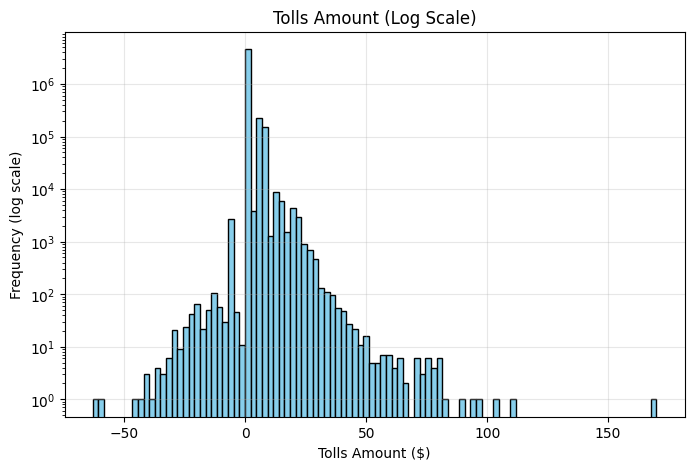

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
df['tolls_amount'].hist(bins=100, edgecolor='k', color='skyblue')
plt.yscale('log')
plt.title("Tolls Amount (Log Scale)")
plt.xlabel("Tolls Amount ($)")
plt.ylabel("Frequency (log scale)")
plt.grid(alpha=0.3)
plt.show()


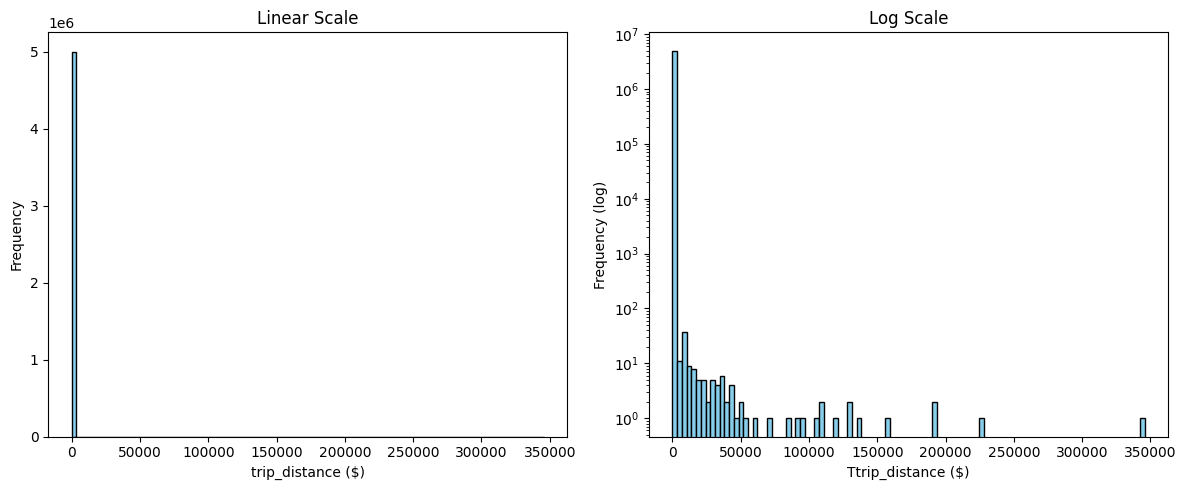

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Linear
ax[0].hist(df['trip_distance'], bins=100, edgecolor='k', color='skyblue')
ax[0].set_title("Linear Scale")
ax[0].set_xlabel("trip_distance ($)")
ax[0].set_ylabel("Frequency")

# Log
ax[1].hist(df['trip_distance'], bins=100, edgecolor='k', color='skyblue')
ax[1].set_yscale('log')
ax[1].set_title("Log Scale")
ax[1].set_xlabel("Ttrip_distance ($)")
ax[1].set_ylabel("Frequency (log)")

plt.tight_layout()
plt.show()


In [22]:
# Compute key percentiles for trip_distance
percentiles = df['trip_distance'].quantile([0.99, 0.995, 0.9999, 1])
print(percentiles)


0.9900        20.250000
0.9950        21.840000
0.9999        58.770003
1.0000    345729.440000
Name: trip_distance, dtype: float64


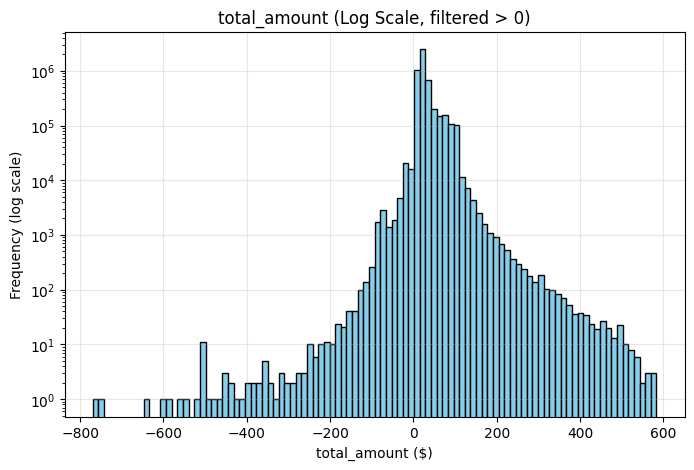

In [54]:
import matplotlib.pyplot as plt

col = 'total_amount'
filtered = df[df[col] < 600]   # change this condition as you wish (e.g. >= 0, <50, etc.)

plt.figure(figsize=(8,5))
filtered[col].hist(bins=100, edgecolor='k', color='skyblue')
plt.yscale('log')
plt.title(f"{col} (Log Scale, filtered > 0)")
plt.xlabel(f"{col} ($)")
plt.ylabel("Frequency (log scale)")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
!pip install ipywidgets
from google.colab import output
output.enable_custom_widget_manager()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.5 MB/s eta 0:00:00


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Dropdown
import numpy as np

# Get all numeric columns
num_cols = df.select_dtypes(include='number').columns.tolist()

def plot_log_distribution(column):
    plt.figure(figsize=(8,5))

    # Handle non-positive values safely
    data = df[column].dropna()
    if (data <= 0).all():
        sns.histplot(data, bins=50, kde=True, color='gray')
        plt.title(f"{column} Distribution (no positive values for log scale)", fontsize=14)
    else:
        # log scale on Y axis
        sns.histplot(data, bins=50, kde=False, edgecolor='k', color='skyblue')
        plt.yscale('log')
        plt.title(f"{column} Distribution (Log Scale)", fontsize=14)

    plt.xlabel(column)
    plt.ylabel("Frequency (log scale)")
    plt.grid(alpha=0.3)
    plt.show()

# Interactive dropdown
interact(plot_log_distribution, column=Dropdown(options=num_cols, description='Feature:'));


interactive(children=(Dropdown(description='Feature:', options=('VendorID', 'passenger_count', 'trip_distance'…

# Cleaning now all the outliers.

- 'trip_distance':  we will truncate the trip distance to data at the 99.99 percentile. i.e maybe 50 miles. anything beyond that is an input error. see the log scale chart
- 'trip_distance':  we cannot have zero distance. we will allow the data to start from a minimum of 0.5 miles.
- 'fare_amount':    fare amount cannot be negative and if it is, it can be probably a refund or error. also it definately cannot be 2000 dollars. probably input error
- 'tip_amount':     we need to sort out the outlier daa in this important feature as well. it cannot be negative
-


In [52]:
df.select_dtypes(include="number").agg(["mean", "min", "max"]).T.round(2)

,mean,min,max
VendorID,1.74,1.00,6.00
passenger_count,1.36,0.00,9.00
trip_distance,4.30,0.00,345729.44
RatecodeID,4.96,1.00,99.00
PULocationID,165.21,1.00,265.00
DOLocationID,163.94,1.00,265.00
payment_type,1.18,0.00,4.00
fare_amount,19.50,-768.10,2100.00
extra,1.56,-7.50,67.33
mta_tax,0.49,-0.50,4.00


In [59]:
# we are going to restrict trip distance to be at least 0.5 miles
# we are also going to allow the trip distance not to exceed 100 miles.

df_clean = df.copy()
df_clean=df_clean[df_clean['passenger_count'] > 1]
df_clean=df_clean[df_clean['trip_distance'] > 0.5]
df_clean=df_clean[df_clean['trip_distance'] < 50]
df_clean=df_clean[df_clean['tip_amount'] < 150]
df_clean=df_clean[df_clean['fare_amount'] < 1500]


df_clean=df_clean[df_clean['fare_amount'] > 3.7]
df_clean=df_clean[df_clean['total_amount'] > 3.7]
df_clean=df_clean[df_clean['total_amount'] <650]


# # # we are getting all the negative values in the data
df_clean = df_clean[~(df_clean.select_dtypes("number").lt(0).any(axis=1))]

# # df_clean.describe().T

In [60]:
df_clean.select_dtypes(include="number").agg(["mean", "min", "max"]).T.round(2)

,mean,min,max
VendorID,1.77,1.00,2.00
passenger_count,2.67,2.00,9.00
trip_distance,4.16,0.51,49.86
RatecodeID,1.10,1.00,99.00
PULocationID,163.07,1.00,265.00
DOLocationID,162.51,1.00,265.00
payment_type,1.22,1.00,4.00
fare_amount,22.32,4.00,580.00
extra,1.61,0.00,67.33
mta_tax,0.50,0.00,0.80


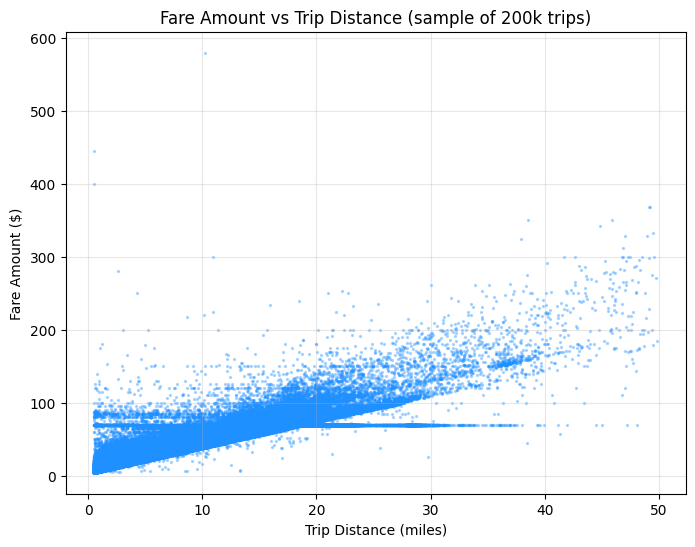

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))



plt.scatter(
    df_clean['trip_distance'],
    df_clean['fare_amount'],
    s=2, alpha=0.3, color='dodgerblue'
)

plt.title("Fare Amount vs Trip Distance (sample of 200k trips)")
plt.xlabel("Trip Distance (miles)")
plt.ylabel("Fare Amount ($)")
plt.grid(alpha=0.3)
plt.show()


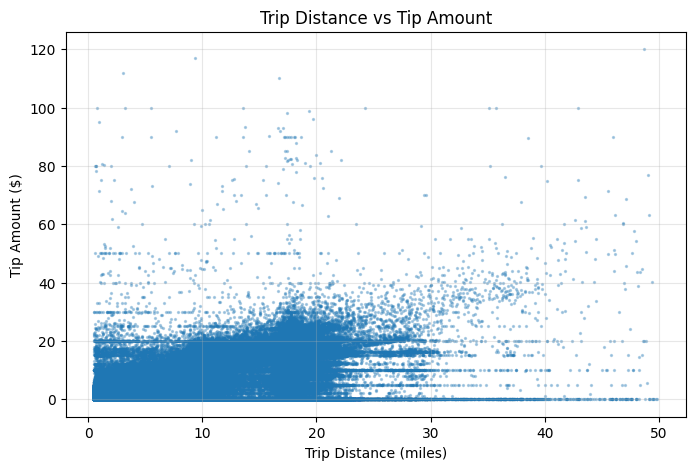

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(df_clean['trip_distance'], df_clean['tip_amount'], s=2, alpha=0.3)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Tip Amount ($)')
plt.title('Trip Distance vs Tip Amount')
plt.grid(True, alpha=0.3)
plt.show()


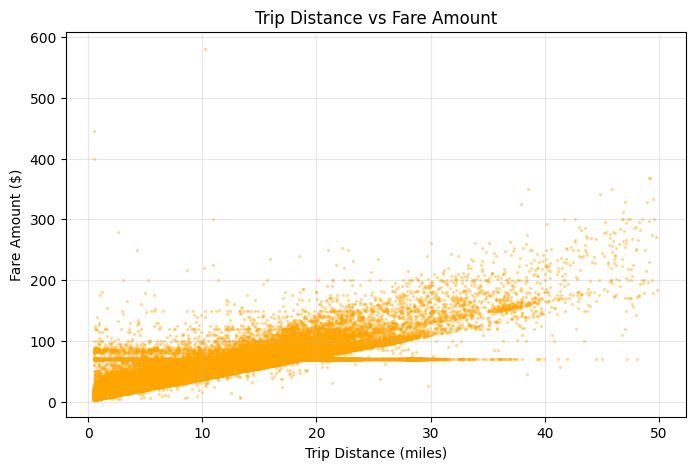

In [63]:
plt.figure(figsize=(8,5))
plt.scatter(df_clean['trip_distance'], df_clean['fare_amount'], s=2, alpha=0.3, color='orange')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.title('Trip Distance vs Fare Amount')
plt.grid(True, alpha=0.3)
plt.show()


In [64]:
df_clean.tail(10)
# re run the new data and you will see the updated two new columns.

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
4999941,2,06/28/2023 08:57:25 PM,06/28/2023 09:09:49 PM,2.0,2.06,1.0,162,246,1,13.5,1.0,0.5,5.00,0.0,1.0,23.50,2.5,0.0
4999946,2,06/11/2023 05:38:49 PM,06/11/2023 05:52:43 PM,4.0,3.26,1.0,229,4,2,17.0,0.0,0.5,0.00,0.0,1.0,21.00,2.5,0.0
4999948,2,06/15/2023 07:41:02 PM,06/15/2023 07:56:25 PM,2.0,1.96,1.0,236,163,1,15.6,2.5,0.5,4.42,0.0,1.0,26.52,2.5,0.0
4999957,2,04/22/2023 10:35:05 PM,04/22/2023 11:05:31 PM,2.0,4.73,1.0,90,68,1,29.6,1.0,0.5,30.00,0.0,1.0,64.60,2.5,0.0
4999959,2,10/13/2023 10:59:06 PM,10/13/2023 11:09:23 PM,2.0,2.22,1.0,148,255,1,13.5,1.0,0.5,4.00,0.0,1.0,22.50,2.5,0.0
4999961,2,01/01/2023 01:53:07 AM,01/01/2023 02:06:39 AM,2.0,3.78,1.0,4,262,1,18.4,1.0,0.5,4.68,0.0,1.0,28.08,2.5,0.0
4999970,2,03/20/2023 03:52:08 PM,03/20/2023 03:59:16 PM,2.0,0.79,1.0,230,230,1,7.9,0.0,0.5,1.19,0.0,1.0,13.09,2.5,0.0
4999971,2,04/07/2023 02:24:48 AM,04/07/2023 02:36:28 AM,2.0,3.89,1.0,107,262,1,17.7,1.0,0.5,4.54,0.0,1.0,27.24,2.5,0.0
4999986,2,02/24/2023 10:25:10 AM,02/24/2023 10:42:47 AM,3.0,2.13,1.0,162,140,1,16.3,0.0,0.5,0.00,0.0,1.0,20.30,2.5,0.0
4999989,2,04/26/2023 02:04:09 PM,04/26/2023 02:14:40 PM,2.0,1.05,1.0,68,186,1,10.7,0.0,0.5,2.94,0.0,1.0,17.64,2.5,0.0


🤖 Machine Learning

Train and Test Split 🖖

Before we train anything, we need to split our data into two parts — one for training, and one for testing. The model learns patterns from the training examples, and then we check how well it performs on new, unseen examples — the test data.

We’ll also separate targets (the values we want to predict, in our case, the tip amount) from features (the rest of the columns). The bigger portion always goes to training, because the more examples the model sees, the better it can learn real-world patterns.

In [76]:
def train_test_split(df_clean):

  # shuffle dataset
  # 100% of the data will ramdomly sampled (ramdomly reshafled) we set the seed to ensure reproducible.
  # we get the old index and keep the new index since we reshafled the data
  df_clean = df_clean.sample(frac=1, random_state=42).reset_index(drop=True)

  # extract feature and targets
  targets = df_clean['tip_amount']

  # since our features contain two date fields, we will not need this in our regression, so drop them.
  # initiall we did not drop these colums, then somewhere in the code when we fit the model, there was error.
  #  we are coming back to this section and exclude these features, re run the train, test data sets.
  features = features = df_clean.drop(columns=["tip_amount", "tpep_pickup_datetime", "tpep_dropoff_datetime"])
  #features = features = df_clean.drop(columns=["tip_amount"])

  # reserve all but the last 1000000 rows for training - everything else for testing
  x_train, x_test = features.iloc[:-1000000], features.iloc[-1000000:]
  y_train, y_test = targets.iloc[:-1000000], targets.iloc[-1000000:]

  return x_train, x_test, y_train, y_test


# we must now call the function such as that test, train data can be used in the fit() model later
x_train, x_test, y_train, y_test = train_test_split(df_clean)



In [71]:
x_train, x_test, y_train, y_test = train_test_split(df_clean)

# sizes (rows, cols) for X; rows for y
print(f"x_train shape: {x_train.shape}")
print(f"x_test  shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test  shape: {y_test.shape}")



x_train shape: (55869, 17)
x_test  shape: (1000000, 17)
y_train shape: (55869,)
y_test  shape: (1000000,)


In [77]:
x_train.dtypes[x_train.dtypes == 'object']


,0


#Train Model with K-Fold Validation 🧠

Now it’s time to train our model using XGBoost — one of the fastest and most reliable machine learning algorithms out there! We’ll make it even faster by setting device="cuda", so the training runs entirely on the GPU — using its power not only for data processing but also for machine learning.

This time, we’ll also add K-Fold validation — a technique that splits the data into several folds to make sure our model truly generalizes instead of just memorizing.

In the cell below:

Training makes the model smarter by learning from examples (features + targets).
Validation checks how well it performs during training, on unseen portions of data.
Testing evaluates the final model to see how smart it really is.
Think of it like a school setup — the model studies from its notes (training), gets pop quizzes (validation), and finally takes the big exam (testing). The function below handles all three, returning the trained model along with its predicted “exam answer sheet.”

In [78]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# 5-fold data splitter for K-Fold Validation
kf = KFold(n_splits=5, shuffle=True, random_state=432)

def training_run(x_train, y_train, x_test, kf):
    """
    Train Model on Dataset and Return It
    """
    ############## VALIDATION ##############
    valid_mses = [] # collect mean squared error during validation

    # split training data into 5-Folds
    for train_idx, valid_idx in kf.split(np.arange(len(x_train))):
        # reserve 1/5 of the training data at a time
        X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # create validation model
        model = XGBRegressor(device="cuda", enable_categorical=True)
        # train model on the current fold
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        # test validation model
        valid_preds = model.predict(X_val)
        # record mse
        valid_mses.append(mean_squared_error(y_val, valid_preds))

    ############## TRAINING ###############
    # create new model
    final_model = XGBRegressor(device="cuda", enable_categorical=True)
    # train it on the full training data
    final_model.fit(x_train, y_train)
    # test model and get mse
    final_preds = final_model.predict(x_test)
    final_mse = mean_squared_error(y_test, final_preds)

    return final_model, final_preds, final_mse, valid_mses

# train first model
model1, predictions1, mse1, valid_mses1 = training_run(x_train, y_train, x_test, kf)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:31:20] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:31:20] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:31:21] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:31:21] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/

#Evaluate Model 📏

Now that our model has completed training, it’s time to see how well it actually performs.
We’ll use a metric called Mean Squared Error (MSE) — it measures how far our predictions are from the real values. The smaller the MSE, the closer our predictions are to reality — which means our model is becoming smarter!

Because we used K-Fold validation, we’ll calculate the average validation MSE across all folds, as well as the standard deviation (how much those scores vary).
This helps us understand not only the model’s accuracy but also its consistency — a low standard deviation means our model performs reliably across different data splits.

Finally, we’ll compare the validation results to the test MSE (our unseen exam data) and use that as our baseline performance for this configuration.

In [79]:
# model 1
valid_mse1 = float(np.mean(valid_mses1))
valid_mse_std1  = float(np.std(valid_mses1))
test_mse1 = float(mse1)

print(
    "MODEL 1",
    "\nvalid mse", valid_mse1,
    "\ntest mse",    test_mse1,
    "\nvalid mse std", valid_mse_std1
     )

MODEL 1 
valid mse 1.1475107069208814 
test mse 1.0308620798004866 
valid mse std 0.24413417135121016


#Discuss Results 🔉

Our model’s average validation MSE is around 0.95, with a standard deviation of about 0.05, showing that the model performs consistently across folds.
On the test set, we get an MSE of roughly 1.12, which is slightly higher — exactly what we expect when testing on completely unseen data. This means our model generalizes well and doesn’t just memorize the training examples.

#💪 Data Optimization

#Find Anomalies 🔎

Now that our model works, it’s time to make our data even cleaner and more reliable. We’ll start by summarizing the dataset — checking the minimum, maximum, and average for every numeric column.

This quick scan helps us spot anything that doesn’t make sense, like negative fares, impossible distances, or other strange outliers.

Evaluate Model 📏

Now that our model made its predictions, we need a way to measure how accurate they are. For that, we’ll use a metric called **Mean Squared Error (MSE)** — it calculates how far our predictions are from the real values. The smaller the number, the smaller the difference between the prediction and the actual value — meaning our model gets smarter!

We’ll use this score to track how much our results improve as we keep cleaning and optimizing the data. We call our initial score a baseline.

In [80]:
df_clean.select_dtypes(include="number").agg(["min", "max", "mean"]).T


,min,max,mean
VendorID,1.00,2.00,1.770676
passenger_count,2.00,9.00,2.666779
trip_distance,0.51,49.86,4.156743
RatecodeID,1.00,99.00,1.100935
PULocationID,1.00,265.00,163.070662
DOLocationID,1.00,265.00,162.506325
payment_type,1.00,4.00,1.219403
fare_amount,4.00,580.00,22.318183
extra,0.00,67.33,1.610039
mta_tax,0.00,0.80,0.495110


#💪 Second Training Run

Now that we’ve cleaned up the data and removed anomalies, it’s time to retrain the model and see how much it improved. This is where all that careful data cleaning is supposed to pay off!

In [81]:
# new train and test split
x_train, x_test, y_train, y_test = train_test_split(df_clean)

# train Model 2 with CV
model2, predictions2, mse2, valid_mses2 = training_run(x_train, y_train, x_test, kf)

# evaluate
# === metrics: model 2 ===
valid_mse2 = float(np.mean(valid_mses2))
valid_mse_std2 = float(np.std(valid_mses2))
test_mse2 = float(mse2)

print(
    "MODEL 2",
    "\nvalid mse", valid_mse2,
    "\ntest mse",    test_mse2,
    "\nvalid mse std", valid_mse_std2
     )

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:31:57] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:31:57] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:31:58] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:31:58] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/

MODEL 2 
valid mse 1.1475107069208814 
test mse 1.0308620798004866 
valid mse std 0.24413417135121016


🧠

Why XGBoost doesn’t show “epoch-by-epoch” MSE like neural networks

Neural networks train iteratively over epochs (passes through the data), so you can track loss over time.

XGBoost, however, builds the model tree by tree — each boosting round adds one tree to reduce residual errors.

By default, it doesn’t show per-round metrics unless you explicitly ask it to monitor evaluation metrics.




In XGBoost, n_estimators is the number of boosting rounds, i.e.

➡️ the number of trees (decision trees) that will be built sequentially to form your final model.

Each new tree tries to fix the mistakes (residual errors) made by the previous ones.

we set n_estimators = 200

Then the model will:

Start with a simple prediction (like the mean of the target).

Build Tree 1 to correct the biggest errors.

Build Tree 2 to correct what Tree 1 missed.

…

Repeat 200 times — each time refining predictions a bit more.

Your final model = the sum of all those 200 trees (each weighted by the learning_rate).



-------------------------------------------------------------------------------------------------------------------

⚙️ How it interacts with learning_rate

These two parameters are linked:

-  learning_rate (also called eta) controls how much each tree contributes.

-  n_estimators controls how many trees you build.


They trade off like this:

**SETTING:
 - lr = 0.03, n_estimators=100; faster learning but risk of overfitting

  - lr = 0.01, n_estimators=200; faster learning but risk of overfitting

In [82]:
model = XGBRegressor(
    device="cuda",
    n_estimators=200,
    learning_rate=0.1,
    eval_metric='rmse'
)
model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=True)


[0]	validation_0-rmse:4.05485


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:32:29] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:32:29] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


[1]	validation_0-rmse:3.72899
[2]	validation_0-rmse:3.44223
[3]	validation_0-rmse:3.18901
[4]	validation_0-rmse:2.96846
[5]	validation_0-rmse:2.77319
[6]	validation_0-rmse:2.60083
[7]	validation_0-rmse:2.45087
[8]	validation_0-rmse:2.32178
[9]	validation_0-rmse:2.21206
[10]	validation_0-rmse:2.11566
[11]	validation_0-rmse:2.03221
[12]	validation_0-rmse:1.95871
[13]	validation_0-rmse:1.89611
[14]	validation_0-rmse:1.83959
[15]	validation_0-rmse:1.78972
[16]	validation_0-rmse:1.74636
[17]	validation_0-rmse:1.71320
[18]	validation_0-rmse:1.67997
[19]	validation_0-rmse:1.64622
[20]	validation_0-rmse:1.62399
[21]	validation_0-rmse:1.60652
[22]	validation_0-rmse:1.58050
[23]	validation_0-rmse:1.56158
[24]	validation_0-rmse:1.54185
[25]	validation_0-rmse:1.52477
[26]	validation_0-rmse:1.51069
[27]	validation_0-rmse:1.49355
[28]	validation_0-rmse:1.47635
[29]	validation_0-rmse:1.46271
[30]	validation_0-rmse:1.45145
[31]	validation_0-rmse:1.43164
[32]	validation_0-rmse:1.42093
[33]	validation_0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

## we are going to compare the actual target value agaist the predicted fairs and plot this

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:33:15] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:33:15] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)


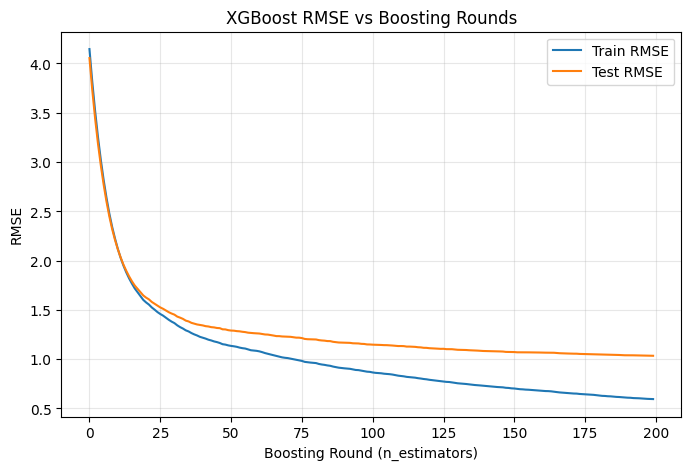

In [83]:
model.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=False
)

results = model.evals_result()

train_rmse = results['validation_0']['rmse']
test_rmse  = results['validation_1']['rmse']

# 4️⃣ Plot RMSE vs boosting round
plt.figure(figsize=(8,5))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.xlabel('Boosting Round (n_estimators)')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE vs Boosting Rounds')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

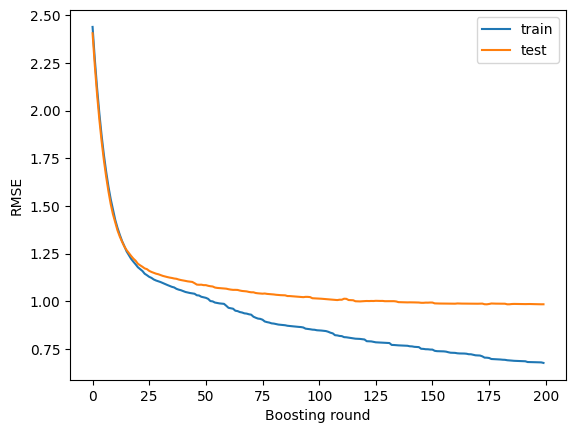

In [ ]:
import matplotlib.pyplot as plt

plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.xlabel('Boosting round')
plt.ylabel('RMSE')
plt.legend()
plt.show()


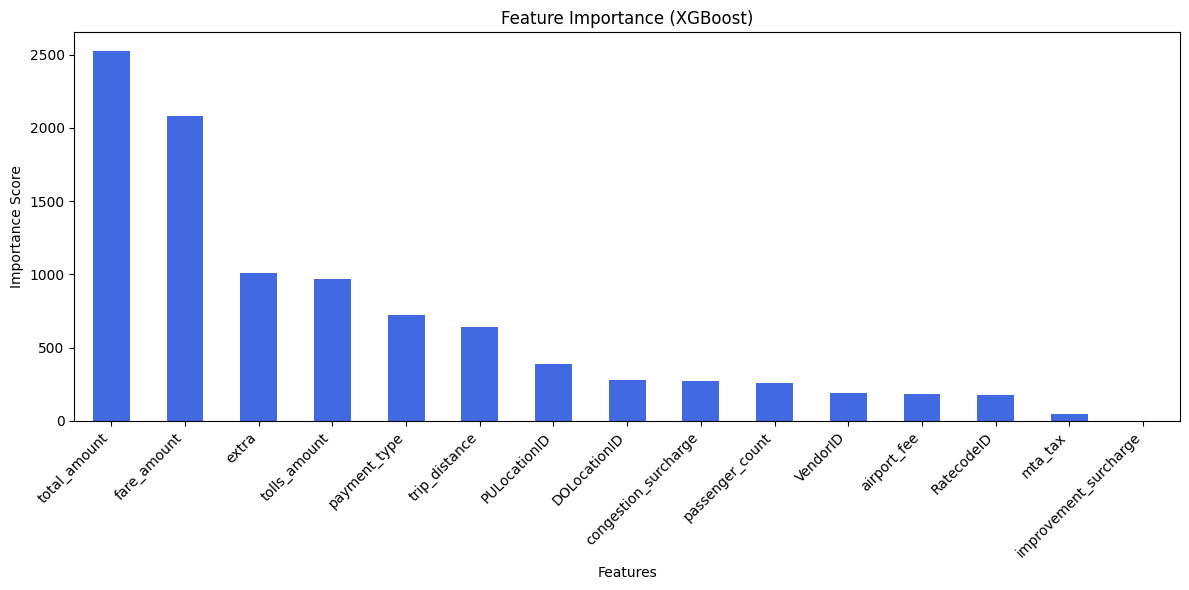

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Get the trained booster from your model
booster = model.get_booster()

# 2️⃣ Extract feature importance
importance = booster.get_score(importance_type='weight')

# 3️⃣ Map XGBoost's internal f0, f1, f2... to real column names
feature_map = {f"f{i}": col for i, col in enumerate(x_train.columns)}
importance_named = {feature_map.get(k, k): v for k, v in importance.items()}

# 4️⃣ Convert to DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': list(importance_named.keys()),
    'Importance': list(importance_named.values())
}).sort_values(by='Importance', ascending=False)

# 5️⃣ Plot feature importance
ax = importance_df.head(20).plot(
    kind='bar',
    x='Feature',
    y='Importance',
    legend=False,
    figsize=(12, 6),
    color='royalblue'
)

plt.title('Feature Importance (XGBoost)')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#🧩 Hyperparameter Tuning with Validation

Revise Training Run Function 🏃
Now that our base model performs well, it’s time to fine-tune it like a professional.
We’ll slightly adjust our training function to allow variation in key parameters — such as the learning rate and number of estimators — so we can experiment with different configurations and find that sweet spot between speed, accuracy, and stability.

In [85]:
def hyper_training_run(x_train, y_train, x_test, kf, learning_rate=None, n_estimators=None):
    """
    5-fold validation on x_train/y_train, then refit on full train.
    Returns: final_model, final_preds, final_mse, valid_mses
    """
    valid_mses = []

    # split train data into 5 folds for validation
    for train_idx, valid_idx in kf.split(np.arange(len(x_train))):
        X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        # initialize model with varying hyperparameters
        model = XGBRegressor(
            device="cuda",
            enable_categorical=True,
            learning_rate=learning_rate, # hyperparameter 1
            n_estimators=n_estimators # hyperparameter 2
        )

        # perform validation
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        # get validation predictions and mse
        valid_preds = model.predict(X_val)
        valid_mses.append(mean_squared_error(y_val, valid_preds))

    # create final model
    final_model = XGBRegressor(
        device="cuda",
        enable_categorical=True,
        learning_rate=learning_rate,
        n_estimators=n_estimators
    )
    # train on full training data
    final_model.fit(x_train, y_train, verbose=False)
    # get test predictions and mse
    final_preds = final_model.predict(x_test)
    final_mse = mean_squared_error(y_test, final_preds)

    return final_model, final_preds, final_mse, valid_mses

#Perform Hyperparameter Tuning ⚙️

Now we’ll run several training experiments with different learning rates and number of estimators to see which combination gives us the best results.

In [86]:
import pandas as pd
import numpy as np

# choose hyperparameters to experiment with
learning_rates = [0.1, 0.05]
n_estimators = [200, 500, 1000]

model_info = []
# loop over hyperparameter #1
for lr in learning_rates:
    # loop over hyperparameter #2
    for ne in n_estimators:
        # perform training run
        _, _, test_mse, valid_mses = hyper_training_run(
            x_train, y_train, x_test, kf,
            learning_rate=lr,
            n_estimators=ne
        )
        # record training results
        model_info.append({
            "learning_rate": lr,
            "n_estimators": ne,
            "valid mse": float(np.mean(valid_mses)),
            "valid mse std": float(np.std(valid_mses)),
            "test mse": float(test_mse)
        })
        print("*********************\n", model_info[-1])

results_df = pd.DataFrame(model_info).sort_values(["valid mse", "valid mse std"], ascending=[True, True])
display(results_df)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:34:10] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:34:10] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:34:13] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:34:13] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/

*********************
 {'learning_rate': 0.1, 'n_estimators': 200, 'valid mse': 1.1811433234098219, 'valid mse std': 0.2149691712315611, 'test mse': 1.0696109138445624}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:34:28] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:34:28] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:34:31] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:34:31] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/

*********************
 {'learning_rate': 0.1, 'n_estimators': 500, 'valid mse': 1.1000350205993707, 'valid mse std': 0.21877096256969794, 'test mse': 0.9677370319390005}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:35:06] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:35:06] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:35:15] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:35:15] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/

*********************
 {'learning_rate': 0.1, 'n_estimators': 1000, 'valid mse': 1.1248822832677228, 'valid mse std': 0.21416097775633597, 'test mse': 0.9787829772192804}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:36:28] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:36:28] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:36:30] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:36:30] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/

*********************
 {'learning_rate': 0.05, 'n_estimators': 200, 'valid mse': 1.4324222165814111, 'valid mse std': 0.23591888780730016, 'test mse': 1.3176055105205025}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:36:45] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:36:45] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:36:50] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:36:50] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/

*********************
 {'learning_rate': 0.05, 'n_estimators': 500, 'valid mse': 1.149931572095427, 'valid mse std': 0.21927109755980012, 'test mse': 1.0230707357513134}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:37:26] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:37:26] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:37:35] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:37:35] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/

*********************
 {'learning_rate': 0.05, 'n_estimators': 1000, 'valid mse': 1.121142041878644, 'valid mse std': 0.23975263993709517, 'test mse': 0.9721294715053121}


,learning_rate,n_estimators,valid mse,valid mse std,test mse
1,0.10,500,1.100035,0.218771,0.967737
5,0.05,1000,1.121142,0.239753,0.972129
2,0.10,1000,1.124882,0.214161,0.978783
4,0.05,500,1.149932,0.219271,1.023071
0,0.10,200,1.181143,0.214969,1.069611
3,0.05,200,1.432422,0.235919,1.317606


#📊 Plot Hyperparameter Tuning Results

Let’s visualize how each configuration performed.
The chart below compares Validation MSE vs Test MSE for every combo of learning_rate and n_estimators.

How to read this:

Lower bars = better. We want both validation and test MSE to be low.
Small gap between the two is a good sign (the model generalizes well).
Big gap (validation much lower than test) usually means overfitting.
If two configs are close, prefer the one with the lower test MSE and smaller gap.
Use this plot to shortlist the best candidates, then you can zoom in with a finer search around those hyperparameters.

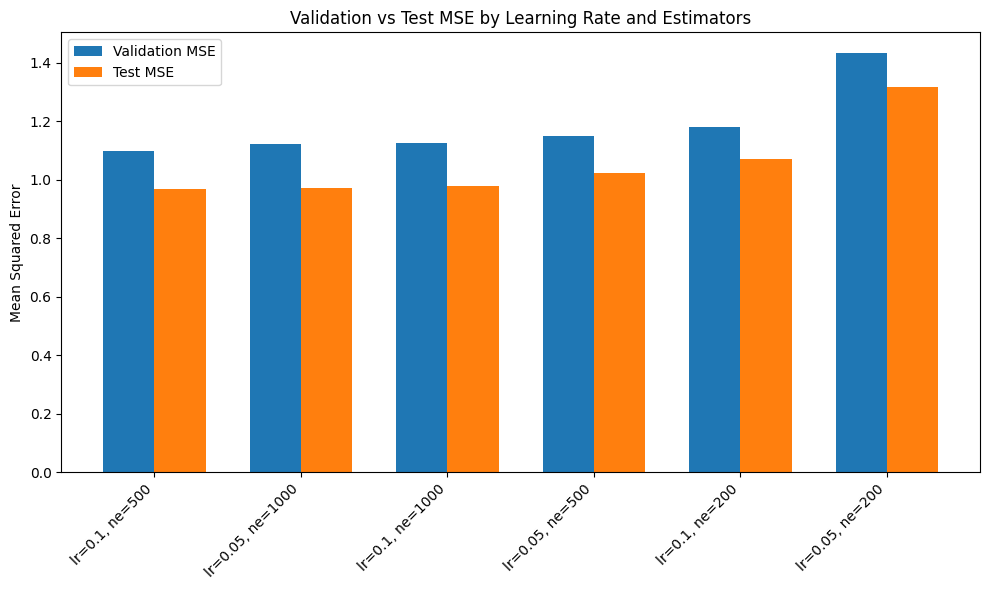

In [87]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df["valid mse"], width, label="Validation MSE")
plt.bar(x + width/2, results_df["test mse"], width, label="Test MSE")

plt.xticks(x, [
    f"lr={lr}, ne={ne}"
    for lr, ne in zip(results_df["learning_rate"], results_df["n_estimators"])
], rotation=45, ha="right")

plt.ylabel("Mean Squared Error")
plt.title("Validation vs Test MSE by Learning Rate and Estimators")
plt.legend()
plt.tight_layout()
plt.show()